## Otimização da Cobrança de Débitos em Serviços Públicos: Estratégias Baseadas em Dados

### Preparação

#### Importação dos dados

In [1]:
from helper_functions import plot_all_cat_freq, remove_outliers, create_stacked_bar_plot
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns

df = pd.read_parquet('utilities_disconnection.parquet')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,"252,39",complete,"662,62",4,2017-03-06,circuit_break,"66,0",circuit_break,"0,0"
1,1,1,14071,1,1,single-phase connection,disconnected,"0,0",None,"1202,45",17,2017-03-31,circuit_break,"73,0",circuit_break,"0,0"
2,2,1,12380,1,1,biphasic connection,disconnected,"0,0",None,"352,56",1,2017-03-20,circuit_break,"20,0",circuit_break,"0,0"
3,3,1,14071,1,1,biphasic connection,disconnected,"1317,25",complete,"699,23",9,2017-03-29,pole,"73,0",pole,"0,0"
4,4,2,22212,1,1,biphasic connection,disconnected,"2172,29",complete,"484,1",4,2017-03-16,pole,"156,0",circuit_break,"0,0"


### Pré-Processamento

#### Tratamento dos tipos de dados

In [2]:
categorical = [
    'client_id',
    'regional', 
    'site', 
    'client_class', 
    'client_subclass', 
    'connection_type', 
    'connection_status', 
    'installment_status', 
    'disconnection_requested',
    'contractor_id',
    'disconnection_executed'
    ]

numerical = [
    'installment_value',
    'total_debt',
    'total_bills',
    ]

datetime = [
    'disconnection_date'
    ]

target = 'collected'

df[categorical] = df[categorical].astype('object')
for col in numerical:
    df[col] = df[col].astype(str).str.replace(",", ".").astype('float')
df[datetime] = df[datetime].apply(pd.to_datetime)
df[target] = df[target].astype(str).str.replace(",",".").astype('float')
df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,252.39,complete,662.62,4.0,2017-03-06,circuit_break,"66,0",circuit_break,0.0
1,1,1,14071,1,1,single-phase connection,disconnected,0.00,None,1202.45,17.0,2017-03-31,circuit_break,"73,0",circuit_break,0.0
2,2,1,12380,1,1,biphasic connection,disconnected,0.00,None,352.56,1.0,2017-03-20,circuit_break,"20,0",circuit_break,0.0
3,3,1,14071,1,1,biphasic connection,disconnected,1317.25,complete,699.23,9.0,2017-03-29,pole,"73,0",pole,0.0
4,4,2,22212,1,1,biphasic connection,disconnected,2172.29,complete,484.10,4.0,2017-03-16,pole,"156,0",circuit_break,0.0


#### Tratamento de valores nulos

In [3]:
df.isna().sum()

client_id                       0
regional                        0
site                            0
client_class                    0
client_subclass                 0
connection_type                 0
connection_status               0
installment_value               0
installment_status         370785
total_debt                      0
total_bills                     0
disconnection_date              0
disconnection_requested         0
contractor_id                   0
disconnection_executed          0
collected                       0
dtype: int64

Pela documentação, esses valores faltantes na coluna ``installment_status`` se referem à casos onde não se aplica, então incluiremos essa nova categoria. 

In [4]:
df.fillna('N/A', inplace=True)

#### Linhas repetidas

In [5]:
print(f'Existem {df.shape[0] - df.drop_duplicates().shape[0]} linhas repetidas')

Existem 142 linhas repetidas


In [6]:
df.drop_duplicates(inplace=True)

### Initial Data Analysis

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

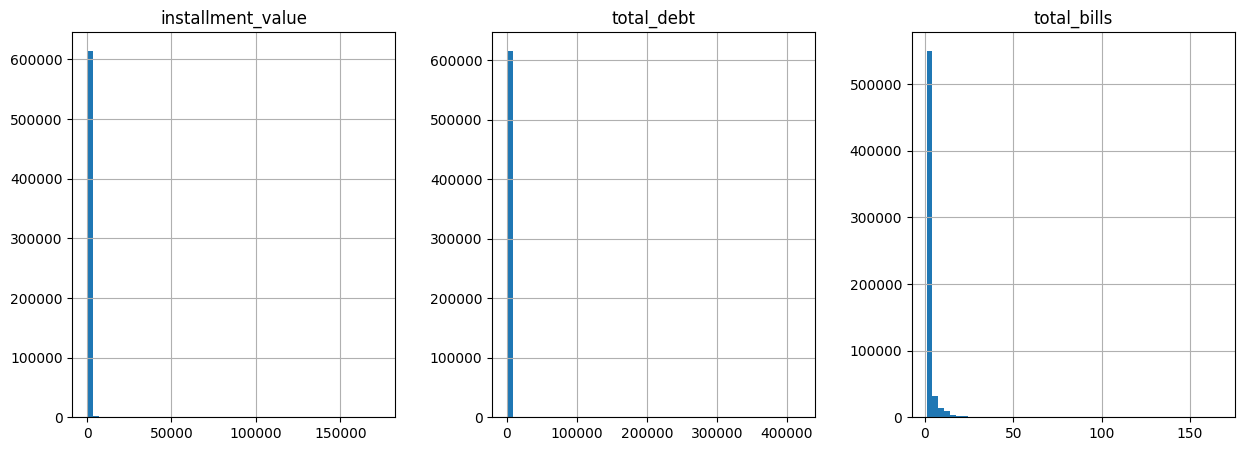

In [7]:
df[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

A distribuição das variáveis numéricas é severamente afetada por outliers

array([[<Axes: title={'center': 'installment_value'}>,
        <Axes: title={'center': 'total_debt'}>,
        <Axes: title={'center': 'total_bills'}>]], dtype=object)

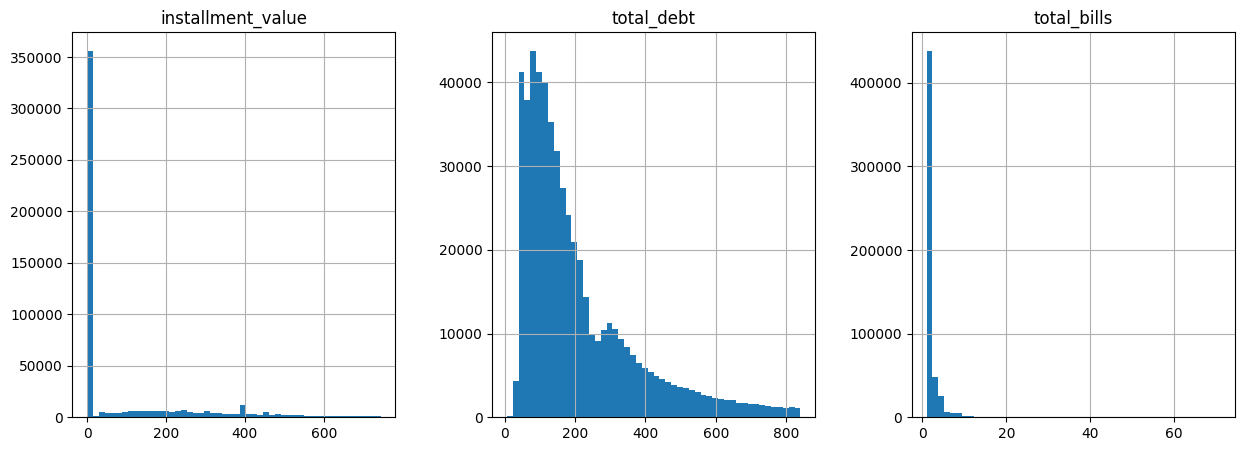

In [8]:
df_filtered = df.loc[df.index.isin(remove_outliers(df[['installment_value', 'total_debt']], bound_const=2))].reset_index(drop=True)
df_filtered[numerical].hist(bins = 50, figsize=(15,5),layout = (1,3))

<Axes: xlabel='total_debt', ylabel='total_bills'>

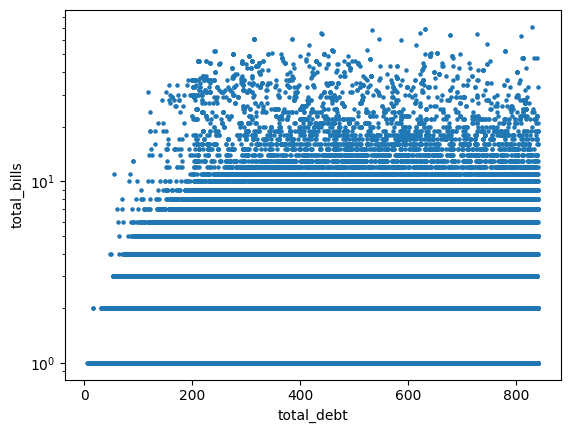

In [9]:
df_filtered.plot(x = 'total_debt', y= 'total_bills', kind = 'scatter', s=5 , logy = True)

Com a remoção de outliers, é possível observar o comportamento dos valores da coluna ``total_debts``, que possui um grande número de registros entre 0 e 250, possuindo um novo pico próximo ao 300 e decaindo a frequência de acordo com o aumento dos valores. 

Tendo essa distribuição em vista, é possível separar os débitos totais em 3 categorias:
- Pequenos débitos: Representam o primeiro pico de distribuição dos débitos, se situando entre 0 e 250
- Médios débitos: Representam a segunda curva, se situando entre 250 e 800
- Altos débitos: Representam valores altos que distoam do comportamento geral dos dados, sendo valores maiores que 800

Pelo segundo gráfico também é possível concluir que para valores baixos do ``total_bills``, existem valores de ``total_debt`` em praticamente todas as faixas, o que significa que existem diferentes valores de contas a serem pagas, se tornando um pouco mais distribuidas (e mais raras) para valores acima de 10.

Com relação à variável ``installment_value`` é possível perceber uma predominância de valores zero, mesmo depois da remoção de outliers.

#### Criando nova coluna com as categorias de total_debt

In [10]:
df['total_debt_class'] = df['total_debt'].apply(lambda x: 'P' if 0 <= x <= 250 else 'M' if 250 < x < 800 else 'G')
categorical.append('total_debt_class')

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

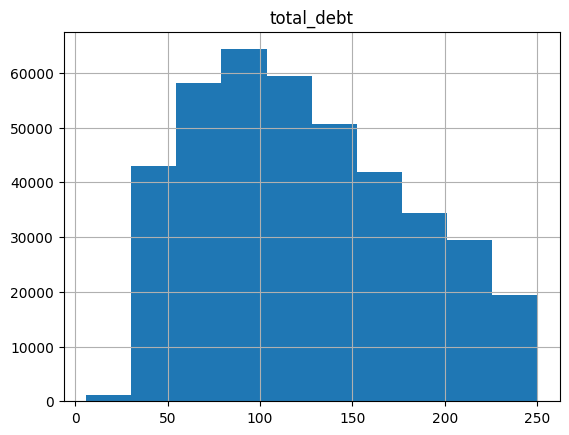

In [11]:
df.loc[df.total_debt_class == 'P',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

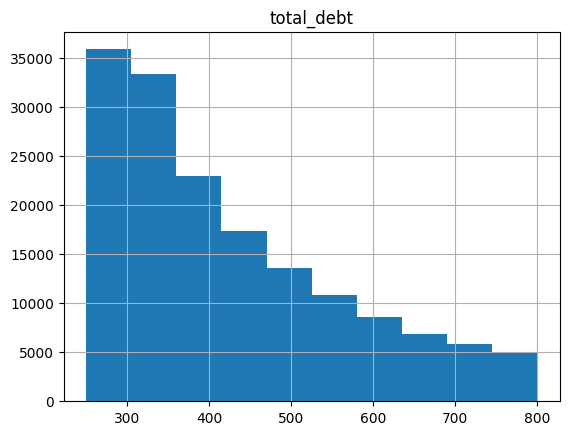

In [12]:
df.loc[df.total_debt_class == 'M',['total_debt']].hist()

array([[<Axes: title={'center': 'total_debt'}>]], dtype=object)

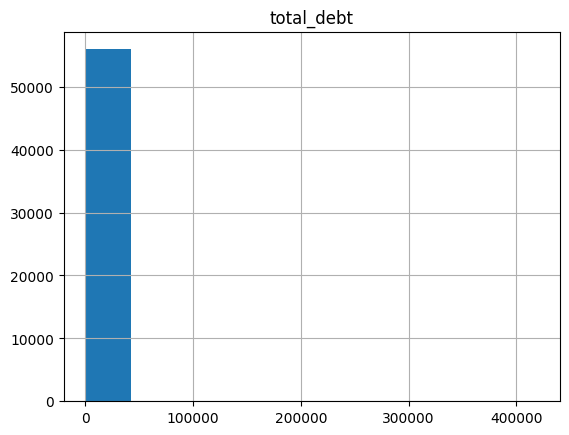

In [13]:
df.loc[df.total_debt_class == 'G',['total_debt']].hist()

#### Explorando variáveis categóricas

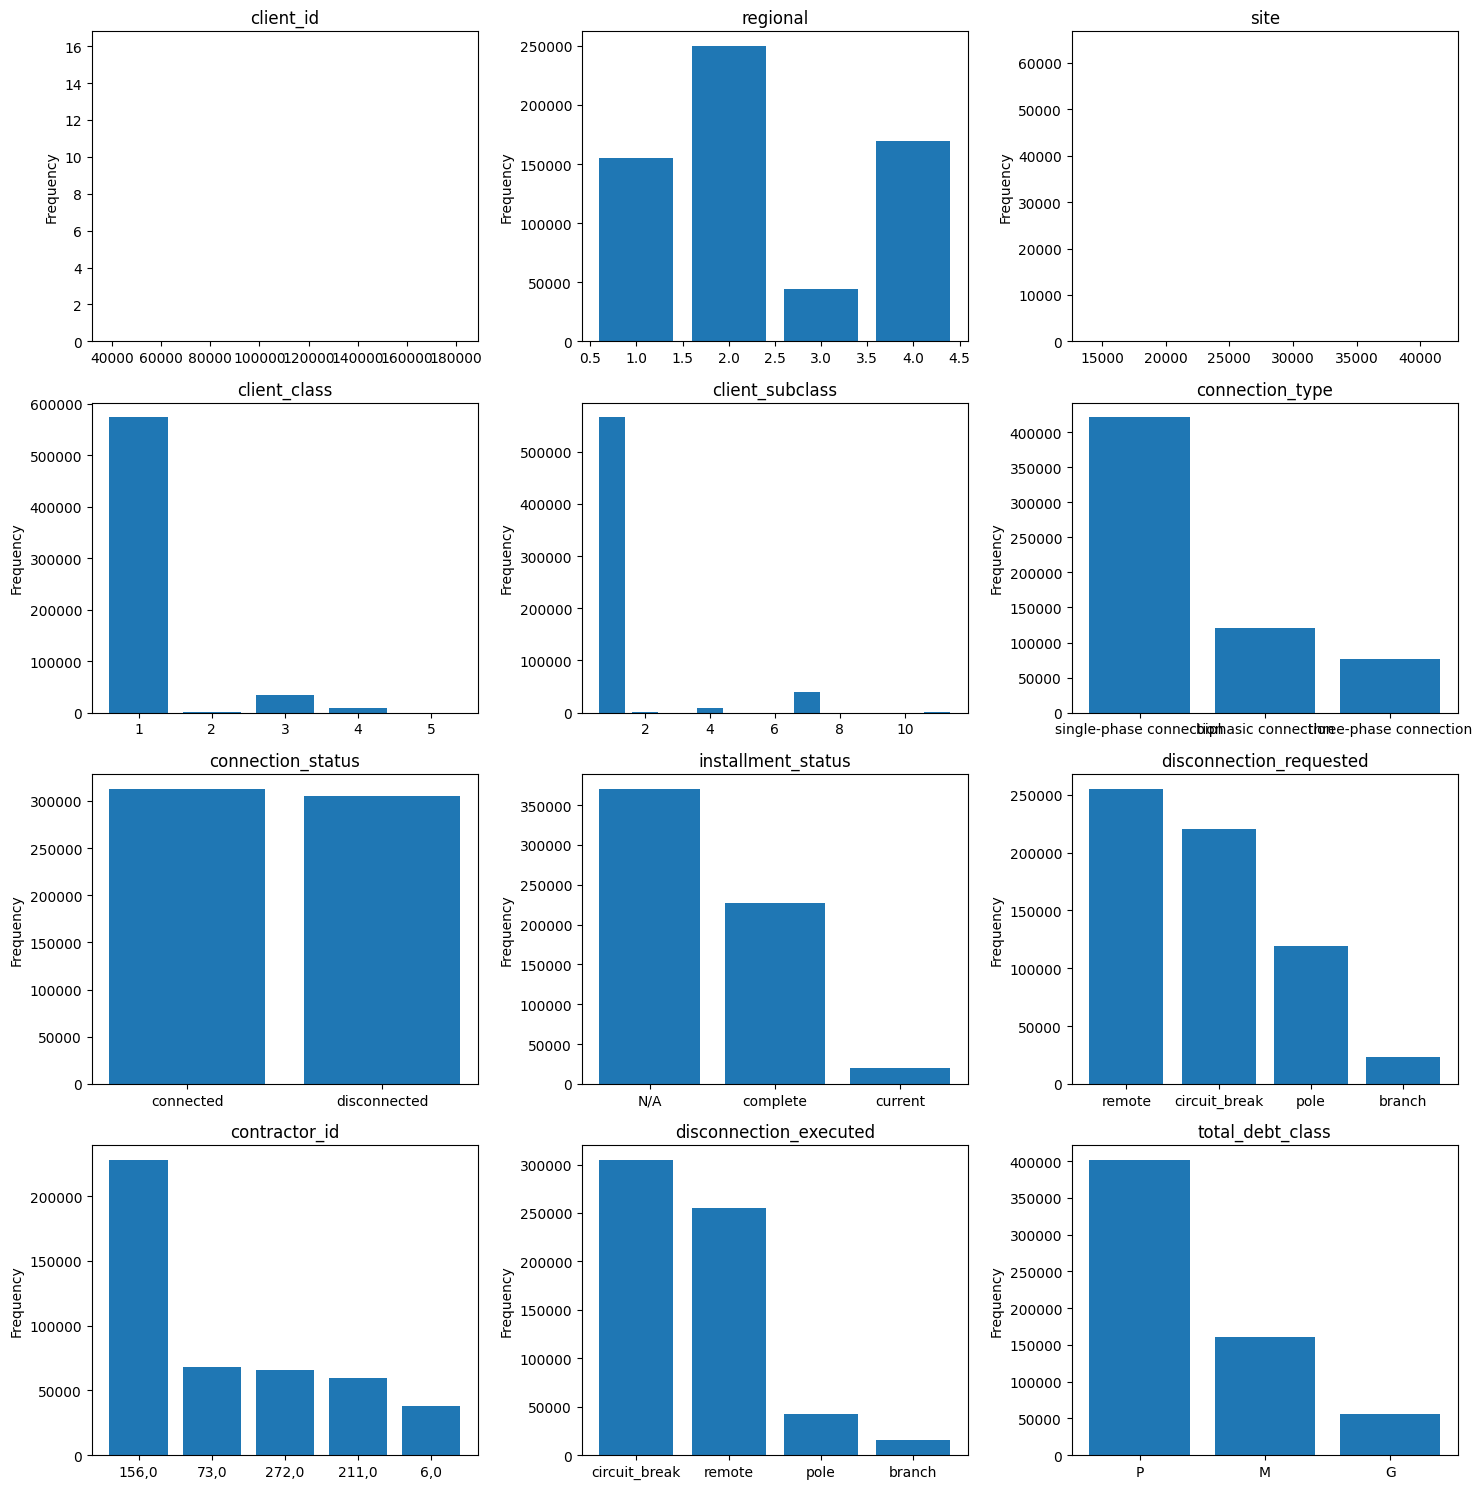

In [14]:
plot_all_cat_freq(df[categorical])

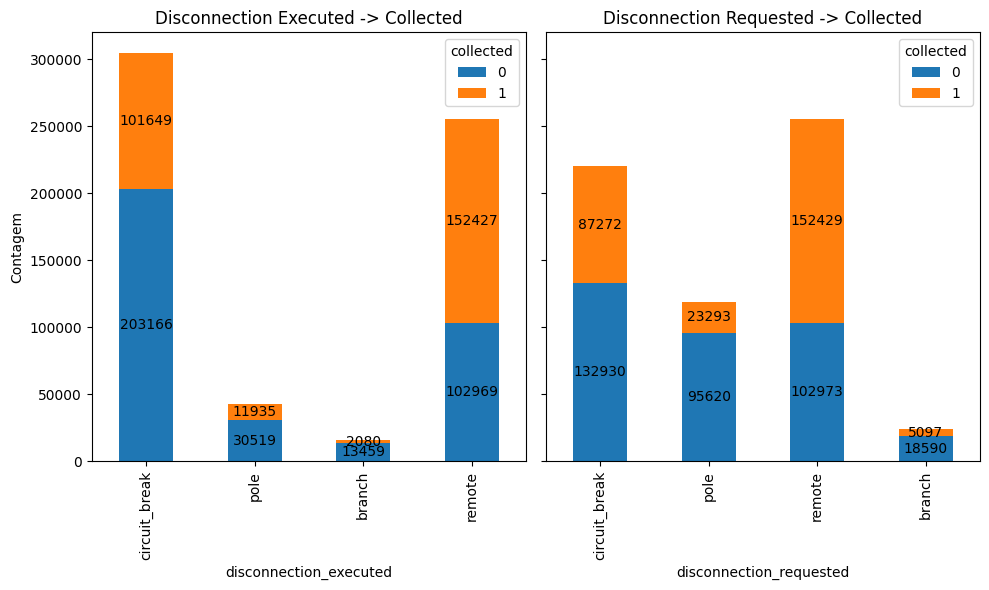

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plotting each analysis
create_stacked_bar_plot(axs[0], df, 'disconnection_executed', 'collected', "Disconnection Executed -> Collected")
create_stacked_bar_plot(axs[1], df, 'disconnection_requested', 'collected', "Disconnection Requested -> Collected")

plt.tight_layout()
plt.show()


In [16]:
df.loc[:,['disconnection_requested', 'disconnection_executed', 'collected']].groupby(['disconnection_requested', 'disconnection_executed']).agg(['count','mean','sum'])

collected                    
                                                   count      mean       sum
disconnection_requested disconnection_executed                              
branch                  branch                      3332  0.192977     643.0
                        circuit_break              16188  0.206079    3336.0
                        pole                        4166  0.268123    1117.0
                        remote                         1  1.000000       1.0
circuit_break           branch                      2198  0.368517     810.0
                        circuit_break             207222  0.394794   81810.0
                        pole                       10774  0.431316    4647.0
                        remote                         8  0.625000       5.0
pole                    branch                     10009  0.062644     627.0
                        circuit_break              81390  0.202666   16495.0
                        pole                       27512  0.224229    6169.0
                        remote                         2  1.000000       2.0
remote                  circuit_break                 15  0.533333       8.0
                        pole                           2  1.000000       2.0
                        remote                    255385  0.596820  152419.0

- Normalmente as requisições para disconexão remota são realmente executas
- Resquisições para disconexão de pole e branch nem sempre são executadas, normalmente reduzidas para disconexão de circuito

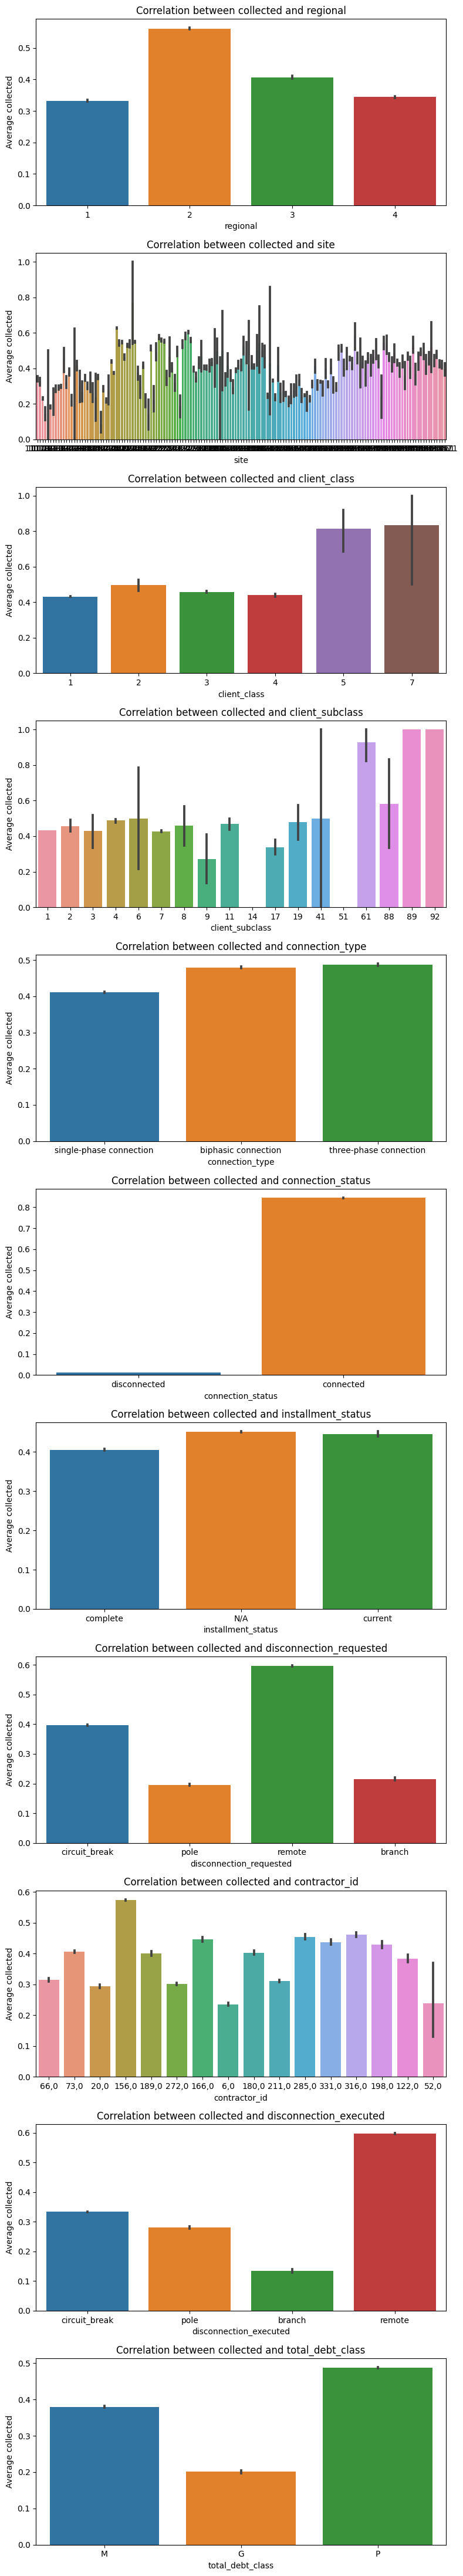

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot correlation with binary variable
def plot_binary_correlation(df, binary_var):
    categorical_vars = [col for col in df.columns if col != binary_var]

    # Initialize a grid of plots
    n_rows = len(categorical_vars)
    fig, axes = plt.subplots(n_rows, 1, figsize=(8, 4 * n_rows))

    # Plot correlation for each categorical variable
    for i, cat_var in enumerate(categorical_vars):
        sns.barplot(data=df, x=cat_var, y=binary_var, ax=axes[i])
        axes[i].set_ylabel('Average ' + binary_var)
        axes[i].set_title('Correlation between ' + binary_var + ' and ' + cat_var)

    plt.tight_layout()
    plt.show()

categorical.remove('client_id')
# Replace 'Binary_Variable' with the name of your binary variable column
plot_binary_correlation(df[categorical+[target]], target)


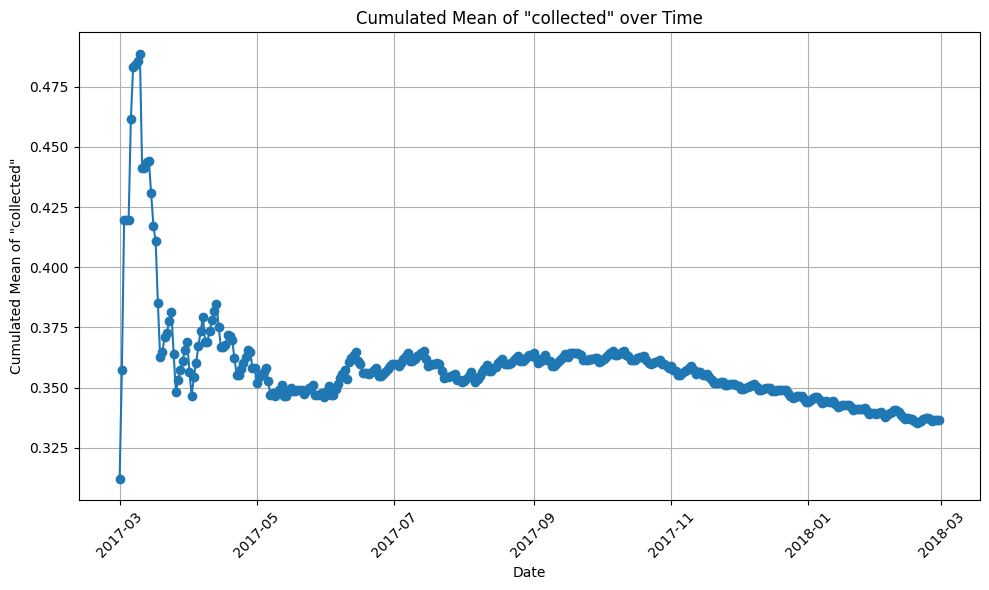

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df_date = df.set_index('disconnection_date')

# Aggregate the dataset daily on mean
df_daily_mean = df_date[['collected']].resample('D').mean()

# Calculate the cumulative mean of the 'collected' binary column
df_daily_mean['Cumulative_Mean'] = df_daily_mean['collected'].expanding().mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_daily_mean.index, df_daily_mean['Cumulative_Mean'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "collected"')
plt.title('Cumulated Mean of "collected" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


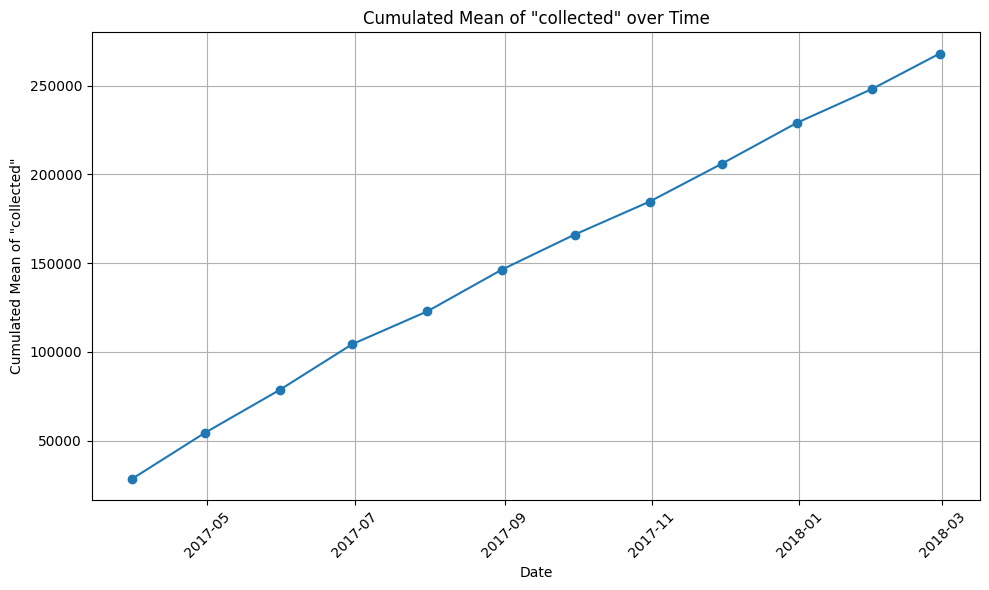

In [19]:
df_date = df.set_index('disconnection_date')

# Aggregate the dataset daily on mean
df_sum = df_date[['collected']].resample('m').sum()

# Calculate the cumulative mean of the 'collected' binary column
df_sum['Cumulative_sum'] = df_sum['collected'].expanding().sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_sum.index, df_sum['Cumulative_sum'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "collected"')
plt.title('Cumulated Mean of "collected" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


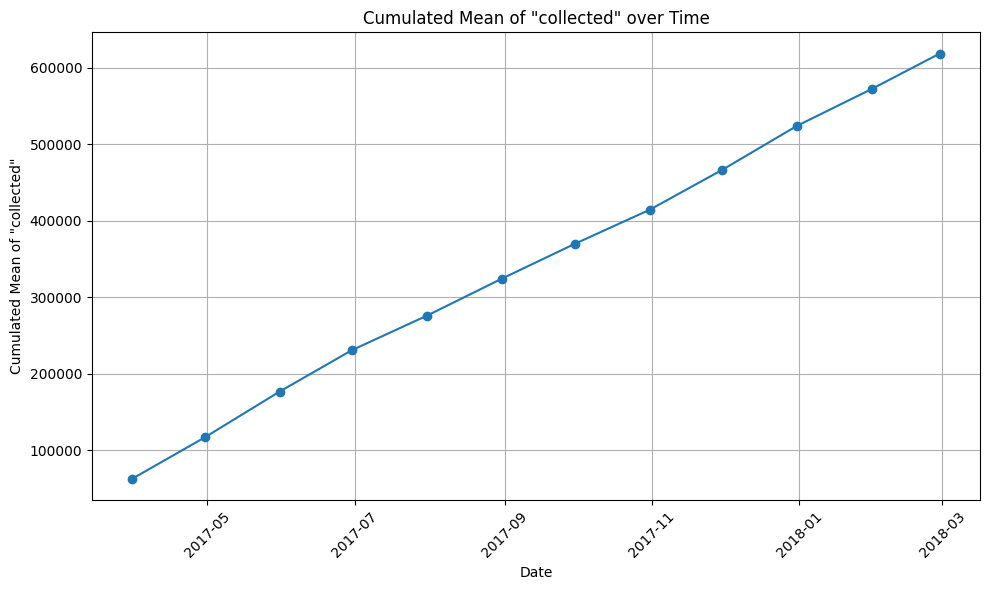

In [20]:
df_date = df.set_index('disconnection_date')

# Aggregate the dataset daily on mean
df_count = df_date[['collected']].resample('M').count()

# Calculate the cumulative mean of the 'collected' binary column
df_count['Cumulative_count'] = df_count['collected'].expanding().sum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_count.index, df_count['Cumulative_count'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Cumulated Mean of "collected"')
plt.title('Cumulated Mean of "collected" over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Escolha de variáveis importantes para a análise da causa raiz

O objetivo do projeto é tornar a metodologia de seleção do pedido de disconexão eficiente, dessa maneira, podemos separar em duas frentes:

- Aumentar a taxa de sucesso de coleta do débito
- Reduzir gastos sem queda de performance da coleta de débito

Tendo esses objetivos em vista, as variáveis que melhor descrevem os casos de uso e que permitirão uma análise de causa raiz são:
- ``client_class``: Essa variável pode auxiliar a trazer características do perfil de cliente
- ``regional``: Também voltada para o perfil do cliente, uma das categorias possui uma taxa de sucesso acima do normal, o que pode ser um bom indício de que ela consegue diferenciar positivos e negativos de maneira eficiente.
- ``connection_status``: Essa categoria se mostrou extremamente relevante, uma vez que possui duas categorias com comportamentos muito distintos, uma com uma taxa muito alta de sucesso e outra com uma taxa muito baixa. Parece ser uma característica essencial.
- ``total_debts``: Essa variável possui um impacto direto na decisão de pagamento do cliente
- ``disconnection_executed``: Essa variável indica a ação executada, que interfere tanto no gasto pela empresa quando na agressividade recebida pelo cliente
- ``total_bills``: Essa variável traz à tona a reincidência do cliente, o que pode indicar uma característica do histórico de pagamento do cliente

### Feature selection

Com o objetivo de prevenir o vazamento de dados e garantir proximidade com o mundo real, a divisão da base é feita antes de todas análises referentes ao modelo.

Como o modelo possui um vínculo temporal, então a base completa será dividida em treino, teste e validação.
- Os dados de treinos serão as informações disponíveis para o modelo executar seu treinamento.
- Os dados de teste serão as informações utilizadas para comparação de métricas de desempenho do modelo.
- Os dados de validação serão as métricas finais do projeto, simulando a previsão para novos dados.

Será feita a divisão de 70% da base para treino, 20% para teste e 10% para validação, sendo essa base de validação composta pelos registros mais recentes.

In [21]:
categorical = [
    'regional', 
    'client_class',
    'connection_status',
    'disconnection_executed'
]
numerical = [
    'total_debt',
    'total_bills'
]
datetime = [
    'disconnection_date'
]

df_n = df.loc[:,categorical+numerical+datetime+[target]]
df_n.head()

,regional,client_class,connection_status,disconnection_executed,total_debt,total_bills,disconnection_date,collected
0,1,1,disconnected,circuit_break,662.62,4.0,2017-03-06,0.0
1,1,1,disconnected,circuit_break,1202.45,17.0,2017-03-31,0.0
2,1,1,disconnected,circuit_break,352.56,1.0,2017-03-20,0.0
3,1,1,disconnected,pole,699.23,9.0,2017-03-29,0.0
4,2,1,disconnected,circuit_break,484.10,4.0,2017-03-16,0.0


In [22]:
TRAIN_RATE = 0.7
TEST_RATE = 0.2
VAL_RATE = 0.1

R_SEED = 42

df_val = df_n.nlargest(int(df_n.shape[0]*VAL_RATE), 'disconnection_date')
aux = df_n.loc[~df_n.index.isin(df_val.index)]
X_train, X_test, y_train, y_test = train_test_split(
    aux.drop(['collected'], axis = 1),
    aux[['collected']], 
    test_size=TEST_RATE/(1-VAL_RATE), 
    random_state=R_SEED,
    stratify=aux[['collected']]
    )

In [23]:
X_train.shape, X_test.shape, df_val.shape

((432743, 7), (123641, 7), (61820, 8))

In [24]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(X_train[categorical])
X_categorical = pd.DataFrame(encoder.transform(X_train[categorical]), columns=encoder.get_feature_names_out())
X_categorical

,regional_1,regional_2,regional_3,regional_4,client_class_1,client_class_2,client_class_3,client_class_4,client_class_5,client_class_7,connection_status_connected,connection_status_disconnected,disconnection_executed_branch,disconnection_executed_circuit_break,disconnection_executed_pole,disconnection_executed_remote
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432738,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
432739,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
432740,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
432741,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train[numerical])
X_numeric_normalized = pd.DataFrame(scaler.transform(X_train[numerical]), columns=numerical)
X_numeric_normalized

,total_debt,total_bills
0,0.030167,0.0
1,-0.370222,0.0
2,-0.074920,0.0
3,0.449481,2.0
4,0.019670,0.0
...,...,...
432738,0.375635,2.0
432739,1.871648,4.0
432740,-0.207075,0.0
432741,0.051779,3.0


In [26]:
# Concatenate one-hot encoded categorical features and normalized numerical features
X_processed = pd.concat([X_categorical, X_numeric_normalized], axis=1)
X_processed

,regional_1,regional_2,regional_3,regional_4,client_class_1,client_class_2,client_class_3,client_class_4,client_class_5,client_class_7,connection_status_connected,connection_status_disconnected,disconnection_executed_branch,disconnection_executed_circuit_break,disconnection_executed_pole,disconnection_executed_remote,total_debt,total_bills
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.030167,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.370222,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.074920,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.449481,2.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.019670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432738,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.375635,2.0
432739,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.871648,4.0
432740,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.207075,0.0
432741,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.051779,3.0


In [27]:
X_categorical_test = pd.DataFrame(encoder.transform(X_test[categorical]), columns=encoder.get_feature_names_out())
X_numeric_normalized_test = pd.DataFrame(scaler.transform(X_test[numerical]), columns=numerical)
X_processed_test = pd.concat([X_categorical_test, X_numeric_normalized_test], axis=1)

In [28]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

mlflow.set_experiment('Primeiros testes')

# Define the parameter grid for each model
param_grid = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'SVC': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    }
}

models = [LogisticRegression, RandomForestClassifier, SVC]

for model in models:
    model_name = model.__name__
    param_grid_model = param_grid[model_name]

    with mlflow.start_run():
        clf = model()
        grid_search = GridSearchCV(clf, param_grid_model, n_jobs=-1, scoring='precision', refit=True)
        grid_search.fit(X_processed, y_train)
        predict = grid_search.predict(X_processed_test)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model", model_name)
        f1 = f1_score(y_test, predict)
        prec = precision_score(y_test, predict)
        rec = recall_score(y_test, predict)
        acc = accuracy_score(y_test, predict)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)


/home/leodomingos/.local/share/virtualenvs/LeonardoDomingosKearney-WYzy48Jh/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/leodomingos/.local/share/virtualenvs/LeonardoDomingosKearney-WYzy48Jh/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/leodomingos/.local/share/virtualenvs/LeonardoDomingosKearney-WYzy48Jh/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/leodomingo

: 

: 

In [28]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.metrics import roc_auc_score
import numpy as np

dtrain = xgb.DMatrix(X_processed, label=y_train)
dtest = xgb.DMatrix(X_processed_test, label=y_test)

def objective(params):
    xgb.set_config(verbosity=0)
    booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=200,
            evals=[(dtest, 'validation')],
            early_stopping_rounds=50,
            verbose_eval= False
        )
    y_pred = booster.predict(dtest)
    metric = 1 - roc_auc_score(y_test, y_pred)

    return {'loss': metric, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 50, 100, 1)),
    'max_delta_step': scope.int(hp.quniform('max_delta_step', 0, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'scale_pos_weight': hp.loguniform('scale_pos_weight', -1, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'eval_metric' : 'auc',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1,
    trials=Trials()
)

100%|██████████| 1/1 [01:04<00:00, 64.43s/trial, best loss: 0.057769172462439955]


In [29]:
best_result['max_depth'] = int(best_result['max_depth'])

In [30]:
best_result['objective'] = 'binary:logistic'
best_result['eval_metric'] = 'auc'
best_result['seed'] = 42

booster = xgb.train(
    params=best_result,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtest, 'validation')],
    early_stopping_rounds=50,
    verbose_eval= False
    )


In [31]:
import mlflow
mlflow.set_experiment('Primeiros testes')
ypred = np.where(booster.predict(dtest) > 0.5, 1,0)
y_true = y_test.T.values[0]
f1 = f1_score(y_true, ypred)
prec = precision_score(y_true, ypred)
rec = recall_score(y_true, ypred)
with mlflow.start_run():
    mlflow.log_params(best_result)
    mlflow.log_param("model", "xgboost")
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)

In [32]:
import mlflow
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

param_grid = {
    "LogisticRegression": {
        "C":[0.01, 0.1, 1, 10,100],
        "fit_intercept": [True, False],
        "penalty": ["l1", "l2", "elasticnet", None],
        "max_iter": [500],
        "n_jobs": [-1],
        "random_state": [42]
    },
    "RandomForestClassifier":{
        "n_estimators": [100, 250, 500, 1000],
        "criterion": ['gini'],
        "max_depth": [None, 10, 50, 100],
        "min_samples_split": [2, 3, 5],
        "max_features": ["sqrt", "log2", None],
        "n_jobs": [-1],
        "random_state": [42]
    },
    "SVC":{
        "C":[0.1, 0.5, 1, 2, 5],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "random_state": [42]
    },
    "test":{
        "C":[1],
        "fit_intercept": [True],
        "penalty": ["l2"],
        "max_iter": [200,500],
        "n_jobs": [-1],
        "random_state": [42]
    }
}
list(ParameterGrid(param_grid["LogisticRegression"]))


[{'C': 0.01,
  'fit_intercept': True,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'l1',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': True,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'l2',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': True,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'elasticnet',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': True,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': None,
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': False,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'l1',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': False,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'l2',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': False,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': 'elasticnet',
  'random_state': 42},
 {'C': 0.01,
  'fit_intercept': False,
  'max_iter': 500,
  'n_jobs': -1,
  'penalty': None,
  'random_state': 42},
 {'C': 0.1,
  'fit_intercept': True,
  'max_iter': 500,
  'n

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

mlflow.set_experiment('Primeiros testes')
models = [LogisticRegression, RandomForestClassifier, SVC]

for model in models:

    with mlflow.start_run():
        model = model()
        lr = GridSearchCV(model, param_grid['test'], n_jobs = -1, scoring=precision_score, refit=True)
        lr.fit(X_processed, y_train)
        predict= lr.predict(X_processed_test)
        mlflow.log_params(param_grid[lr.__class__.__name__])
        mlflow.log_param("model", lr.__class__.__name__)        
        f1 = f1_score(y_test, predict)
        prec = precision_score(y_test, predict)
        rec = recall_score(y_test, predict)
        acc = accuracy_score(y_test, predict)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("accuracy", acc)
    break

: 

: 

In [35]:
y_test.sum()/y_test.shape[0]

collected    0.435842
dtype: float64